Causal impact analysis

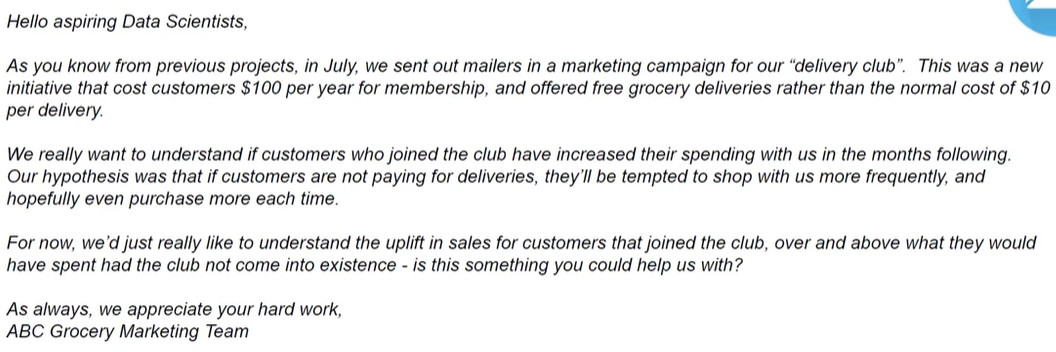

measure the effect of the delivery campaign that they ran
we have data on who was mailed each type of mailer
it was sent to everyone so the control group does not represent a clean group

use customers who did not sign up as out control. event date july the first. the customers who did not sign up represent a relationship with the customers who did sign up as they wouldnt be affected by the event 

In [1]:
#################################################
# import required packages
#################################################
from causalimpact import CausalImpact
import pandas as pd

In [2]:
#################################################
# import and create data
#################################################

# import data tables
transactions = pd.read_excel('Saved_files/grocery_database.xlsx', sheet_name='transactions')
campaign_data = pd.read_excel('Saved_files/grocery_database.xlsx', sheet_name='campaign_data')
print(transactions.shape)
transactions.head()

(38506, 6)


,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


In [3]:
print(campaign_data.shape)
campaign_data.head()


(870, 5)


,customer_id,campaign_name,campaign_date,mailer_type,signup_flag
0,74,delivery_club,2020-07-01,Mailer1,1
1,524,delivery_club,2020-07-01,Mailer1,1
2,607,delivery_club,2020-07-01,Mailer2,1
3,343,delivery_club,2020-07-01,Mailer1,0
4,322,delivery_club,2020-07-01,Mailer2,1


In [4]:
# aggregate transactions data to customer, data level
customer_daily_sales = transactions.groupby(['customer_id',
                                             'transaction_date'])['sales_cost'].\
                                                sum().\
                                                    reset_index()
print(customer_daily_sales.shape)
customer_daily_sales.head()

(16979, 3)


,customer_id,transaction_date,sales_cost
0,1,2020-04-10,26.87
1,1,2020-06-02,65.49
2,1,2020-06-10,71.71
3,1,2020-06-19,61.91
4,1,2020-07-02,471.71


In [5]:
# merge on signup flag 
customer_daily_sales = pd.merge(customer_daily_sales, 
                                campaign_data, 
                                how='inner', 
                                on='customer_id')
print(customer_daily_sales.shape)
customer_daily_sales.head()

(16979, 7)


,customer_id,transaction_date,sales_cost,campaign_name,campaign_date,mailer_type,signup_flag
0,1,2020-04-10,26.87,delivery_club,2020-07-01,Mailer2,1
1,1,2020-06-02,65.49,delivery_club,2020-07-01,Mailer2,1
2,1,2020-06-10,71.71,delivery_club,2020-07-01,Mailer2,1
3,1,2020-06-19,61.91,delivery_club,2020-07-01,Mailer2,1
4,1,2020-07-02,471.71,delivery_club,2020-07-01,Mailer2,1


In [6]:
# pivot the data to aggregate daily sales by sign up group
causal_impact_df = customer_daily_sales.pivot_table(index='transaction_date',
                                                    columns='signup_flag',
                                                    values='sales_cost',
                                                    aggfunc='mean')
print(causal_impact_df.shape)
causal_impact_df.head()

(183, 2)


signup_flag,0,1
transaction_date,,
2020-04-01,74.463333,194.488065
2020-04-02,75.558254,185.161667
2020-04-03,74.387353,118.121333
2020-04-04,63.003797,198.525357
2020-04-05,72.440441,145.456000


In [7]:
# provide a frequency for our dateTime index (avoids a warning message)
causal_impact_df.index

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10',
               ...
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='transaction_date', length=183, freq=None)

freg none will give a warining message

In [8]:
causal_impact_df.index.freq = 'D'

In [9]:
# for causal impact we need the impacte group in th first column
causal_impact_df = causal_impact_df[[1,0]]
print(causal_impact_df.shape)
causal_impact_df.head()

(183, 2)


signup_flag,1,0
transaction_date,,
2020-04-01,194.488065,74.463333
2020-04-02,185.161667,75.558254
2020-04-03,118.121333,74.387353
2020-04-04,198.525357,63.003797
2020-04-05,145.456000,72.440441


In [10]:
# rename columns to something more meaningful
causal_impact_df.columns = ['member', 'non_member']

causal impact likes it as a list

In [11]:
#################################################
# apply causal impact
#################################################
pre_period = ['2020-04-01', '2020-06-30']
post_period = ['2020-07-01', '2020-09-30']

ci = CausalImpact(causal_impact_df, pre_period, post_period)

c:\Users\eacalder\.conda\envs\DSInfinity\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(


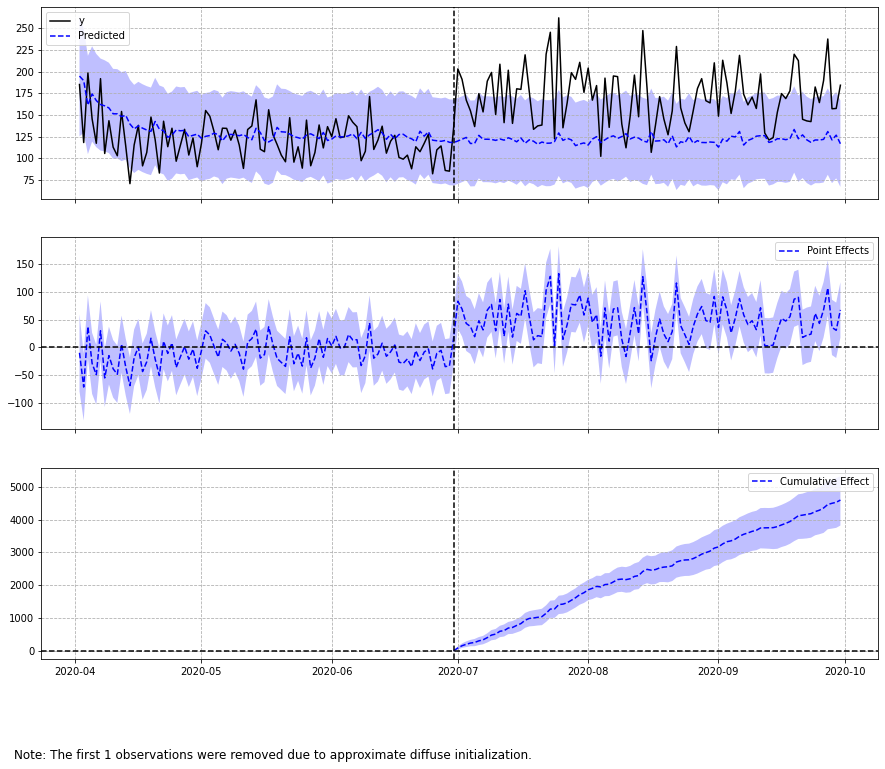

In [12]:
#################################################
# plot the impact
#################################################
ci.plot() 

left of the line is the pre period and right is the post period 
1st of july is the date of the membership


In [13]:
#################################################
# extract the summary statistics and report
#################################################
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    171.33             15762.67
Prediction (s.d.)         121.42 (4.16)      11170.19 (383.08)
95% CI                    [113.54, 129.86]   [10445.81, 11947.45]

Absolute effect (s.d.)    49.92 (4.16)       4592.48 (383.08)
95% CI                    [41.47, 57.79]     [3815.22, 5316.86]

Relative effect (s.d.)    41.11% (3.43%)     41.11% (3.43%)
95% CI                    [34.16%, 47.6%]    [34.16%, 47.6%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [14]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 171.33. By contrast, in the absence of an
intervention, we would have expected an average response of 121.42.
The 95% interval of this counterfactual prediction is [113.54, 129.86].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 49.92 with a 95% interval of
[41.47, 57.79]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 15762.67.
By contrast, had the intervention not taken place, we would have expected
a sum of 11170.19. The 95% interval of this prediction is [10445.81, 11947.45].


The above results are given in terms of absolute numbers. In relative
terms, the res